In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, BatchNormalization, GlobalAvgPool2D
import shap

2024-09-07 10:20:43.337735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 10:20:43.676746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 10:20:43.678924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 10:20:44.583687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [6]:
x_train.shape

(60000, 28, 28, 1)

In [7]:
model = tf.keras.Sequential(
    [
        Input(shape=(28,28,1)),
        Conv2D(32, (3,3), activation='relu'),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(),

        GlobalAvgPool2D(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')

        
    ]
)

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, batch_size=64, epochs=1, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples


2024-09-07 10:20:53.598881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-09-07 10:20:53.620428: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-09-07 10:20:53.784007: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/dense_1/kernel/m/Assign' id:335 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/m, training/Adam/dense_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - ETA: 0s - loss: 0.6495 - acc: 0.7910

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-09-07 10:21:59.523946: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:169 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - 69s 1ms/sample - loss: 0.6495 - acc: 0.7910 - val_loss: 0.3695 - val_acc: 0.8876


In [10]:
model.evaluate(x_test, y_test, batch_size=64)

[0.3682940366983414, 0.8934]

### SHAP ANALYSIS using Deep Explainer!!

It is based on the approximate method to calculate the array of shapley value using few random samples.

This is one of the most basic feature to explore/compute Shapley value for 

In [23]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5 , replace=False)]
# Use DeepExplainer to explain predictions of the model

# modelif framework == ‘tensorflow’, (input[tf.Tensor], outputtf.Tensor)


e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

# Compute shap values
testing_instances = x_test[0:7]
shap_values = e.shap_values(testing_instances)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [24]:
# shap_values = np.array(shap_values)
shap_values[1].shape , testing_instances.shape ## 4D is used!!

((7, 28, 28, 1), (7, 28, 28, 1))

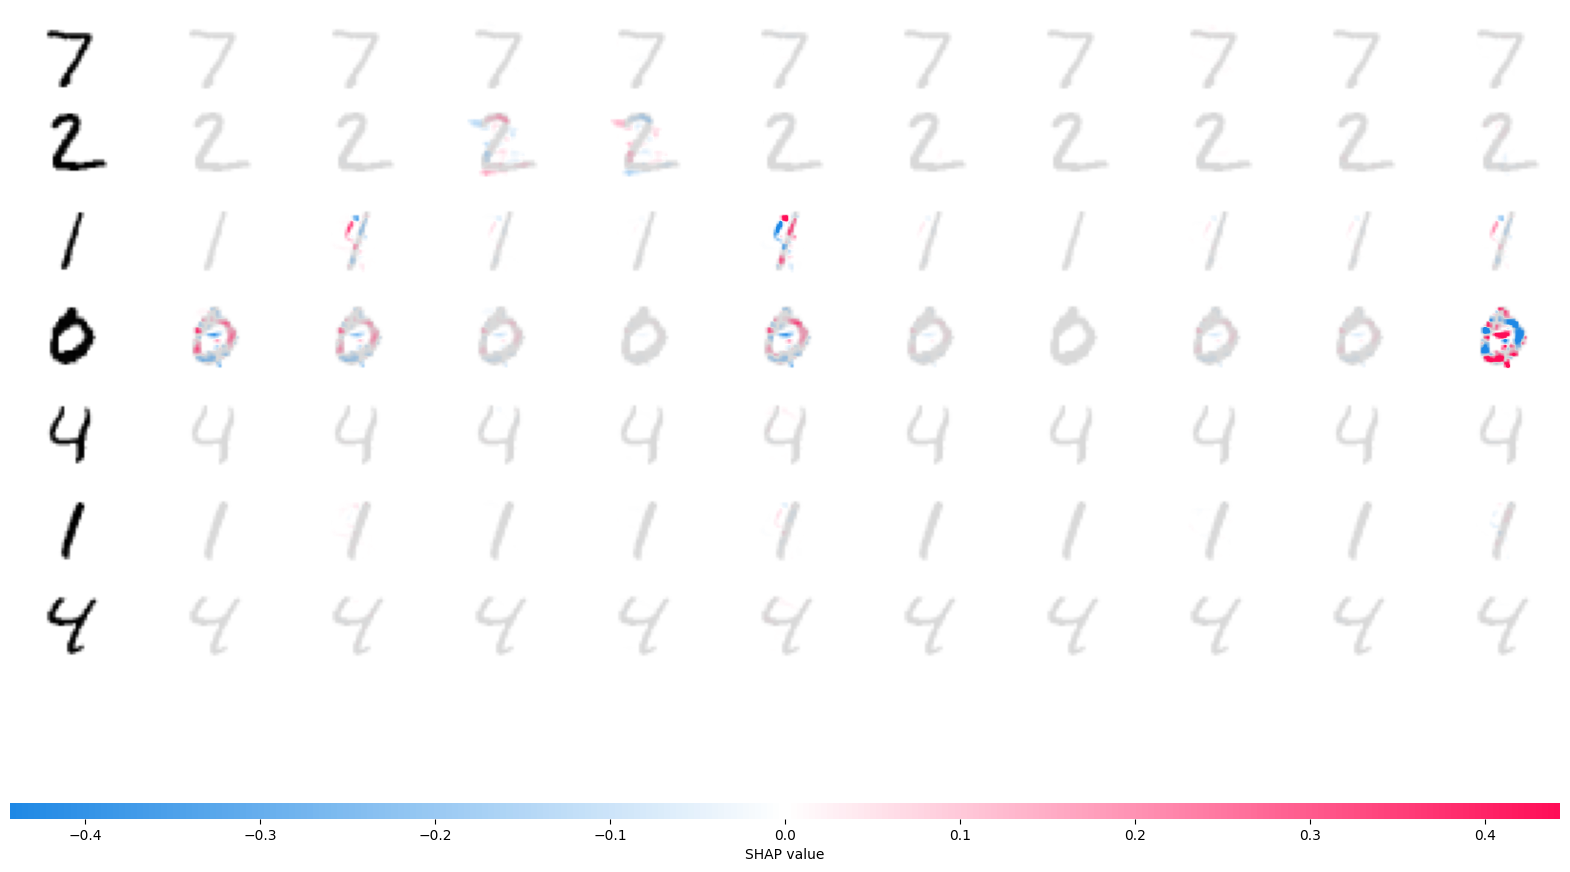

In [25]:
# shap_values = e.shap_values(x_test[0:7])
shap.image_plot(shap_values, -testing_instances)

### More analysis to be done: 

We are mostly interested in each features contribution for all the examples (test dataset)

1. Summary plot.
2. Partition function.
3. Dependance plot.
4. Beeswarm plot.

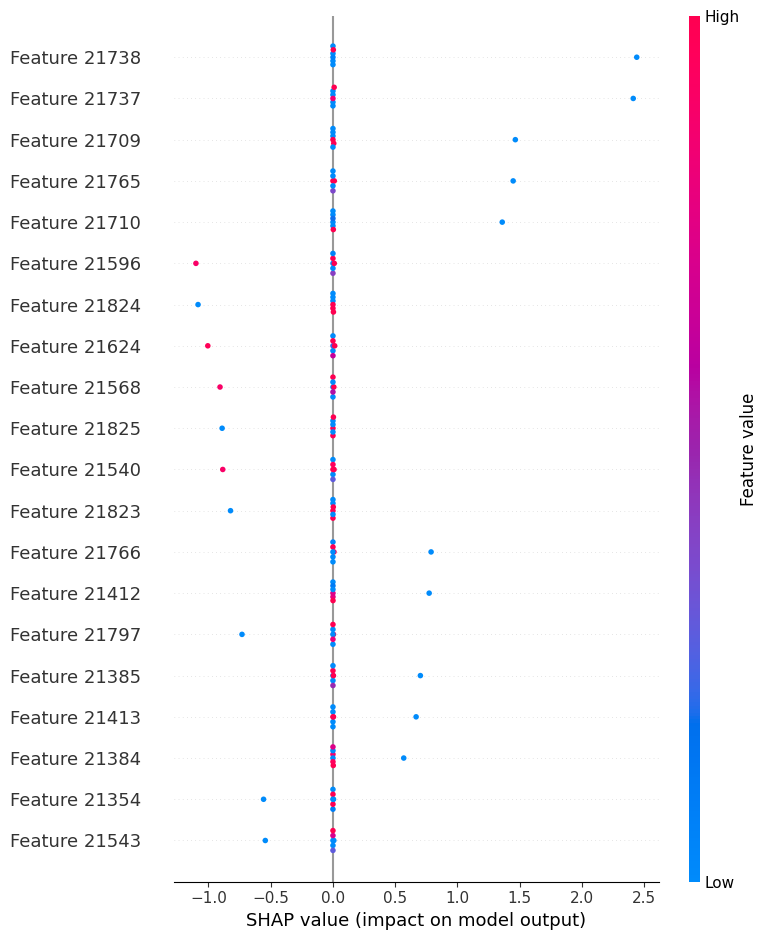

In [20]:
# Plot a summary plot for a specific pixel feature
# shap.dependence_plot((10, 10, 0), shap_values[0][0:7], x_test[0:7], show=False)
shap_values_flat = shap_values[0][0:len(testing_instances)].reshape(7, -1)
x_test_flat = testing_instances.reshape(7, -1)
shap.summary_plot( shap_values_flat, x_test_flat)
## Shap-value for 8 test examples for 784 instances.

In [ ]:
print(shap_values_flat.shape)
print(x_test_flat.shape)